# Autoencoder on global data

# 0. Imports

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset

import matplotlib.pyplot as plt

import keras
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, AveragePooling2D, BatchNormalization
from keras.models import Model, load_model
from keras.optimizers import RMSprop, Adam, Adagrad
from keras import regularizers

from sklearn.model_selection import train_test_split

import gc #garbace collector
import multiprocessing as mp

import os

Using TensorFlow backend.
/home/sebastian/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sebastian/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sebastian/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sebastian/a

# 1. Custom functions

#### Reflection Padding class

In [2]:
import tensorflow as tf
from keras.engine.topology import Layer
from keras.engine import InputSpec

import math
from keras import backend as K

In [3]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

#### Charbonnier loss

A General and Adaptive Robust Loss Function - Jonathan T. Barron, Google Research <br>
https://arxiv.org/pdf/1701.03077.pdf

In [4]:
def charbonnier(y_true, y_pred):
    epsilon = 1e-8
    error = y_true - y_pred
    p = K.sqrt(K.square(error) + epsilon)
    return K.mean(p)

#### PSNR for image quality measurement

In [5]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return 10.0 / math.log(10) * K.log((max_pixel**2) / (K.mean(K.square(y_pred - y_true + 1e-8), axis=-1)))

def PSNR_np(y_true, y_pred):
    max_pixel = 1.0
    return 10.0 / np.log(10) * np.log((max_pixel**2) / (np.mean((y_pred - y_true + 1e-8)**2)))

# 2. Loading the data

In [6]:
nc = Dataset('GEBCO_2019.nc', 'r')
dim1 = int(np.array(nc.variables['lon']).shape[0])
dim2 = int(np.array(nc.variables['lat']).shape[0])
Z = np.flip(np.array(nc.variables['elevation']), axis=0) #otherwise the 'map' is upside down and mirrored

Hawaii = None

In [7]:
dim1, dim2, Z.shape

(86400, 43200, (43200, 86400))

#### To use only Hawaii:


nc = Dataset('tohoku_gebco_ucsb3_2000m_hawaii_bath.nc', 'r')
Hawaii = True

dim1 = int(np.array(nc.variables['x']).shape[0])
dim2 = int(np.array(nc.variables['y']).shape[0])
Z = np.flip(np.array(nc.variables['z']), axis=0)


In [15]:
nc = Dataset('tohoku_2020/tohoku_2020.nc', 'r')
Hawaii = True

dim1 = int(np.array(nc.variables['lon']).shape[0])
dim2 = int(np.array(nc.variables['lat']).shape[0])
Z = np.flip(np.array(nc.variables['elevation']), axis=0)

In [8]:
#plt.matshow(Z_in)

# 3. Pre-processing

#### 'Remove' altitudes > 0 by setting their values to be 0.

In [9]:
#Z[Z>0] = 0

#### Offset values to be non-negative

In [16]:
Z_min = np.min(Z)
Z = Z + np.abs(Z_min)

#### Rescaling to [0, 1]

In [17]:
Z_max = np.max(Z)
Z_max

Z = Z / Z_max

#### Plot the map

In [18]:
#plt.matshow(Z)

#### Create 3-dimensional array containing num_images small pictures.

In [19]:
x, y = 96, 96

num_images = int(dim1*dim2 / (x*y))
num_images

17805

In [20]:
ratio_x = dim1/x
ratio_y = dim2/y

ratio_x, ratio_y

(184.6875, 96.40625)

In [21]:
cutoff_x = int(x * (ratio_x-int(ratio_x)))
cutoff_y = int(y * (ratio_y-int(ratio_y)))
    
cutoff_x, cutoff_y

(66, 39)

In [22]:
data = np.zeros([num_images, y, x])
i=0
for r in range(0, Z.shape[0]-cutoff_y, y):
    for c in range(0, Z.shape[1]-cutoff_x, x):
        data[i, :, :] = Z[r:r+y, c:c+x]
        i = i + 1

In [23]:
if Hawaii==True:
    for i in range(data.shape[0]):
        data[i,:,:] = data[i,:,:].T

#### Split into train and test set

In [24]:
#def split_1(queue, data):
#    result = train_test_split(data, test_size=0.01)
#    queue.put(result)

In [25]:
#queue = mp.Queue()
#p = mp.Process(target=split_1, args=(queue, data_augmented))
#p.start()
#p.join()

#results = queue.get()

#p.close()



In [26]:
#gc.collect()

In [27]:
test_size = 0.05
X_training, X_test = train_test_split(data, test_size=test_size, random_state=7)

## Data Augmentation

Add 90-degree rotations as augmented data

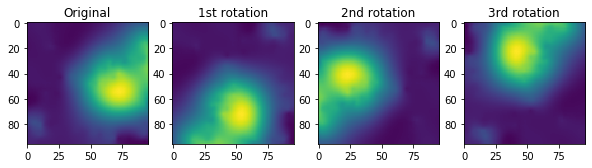

In [28]:
plt.figure(figsize=(10, 4))

plt.subplot(1,4,1)
plt.imshow(X_training[33, ...])
plt.title("Original")

plt.subplot(1,4,2)
plt.imshow(X_training[33, ...].T)
plt.title("1st rotation")

plt.subplot(1,4,3)
plt.imshow(np.flip(X_training[33, ...]))
plt.title("2nd rotation")

plt.subplot(1,4,4)
plt.imshow(np.flip(X_training[33, ...].T))
plt.title("3rd rotation")

plt.show()

In [29]:
index = int(num_images*(1-test_size))
X_train = np.zeros([index*2, y, x])
X_train[0:index, :, :] = X_training

In [30]:
for j in range(index):
    X_train[index*1 + j, :, :] = X_training[j, :, :].T
    #X_train[index*2 + j, :, :] = np.flip(X_training[j, :, :])
    #X_train[index*3 + j, :, :] = np.flip(X_training[j, :, :].T)

In [31]:
X_training.shape, X_train.shape

((16914, 96, 96), (33828, 96, 96))

#### Reshaping for Keras

In [32]:
X_train = X_train.reshape(-1, y, x, 1)
X_test = X_test.reshape(-1, y, x, 1)
X_train.shape, X_test.shape

((33828, 96, 96, 1), (891, 96, 96, 1))

In [33]:
X_train.dtype, X_test.dtype

(dtype('float64'), dtype('float64'))

#### Free up some memory

In [34]:
X_training = None

In [35]:
gc.collect()

8414

#### Create validation and "ground-truth" sets

In [36]:
X_train, X_val, GT_train, GT_val = train_test_split(X_train, X_train, test_size=0.05, random_state=7)

In [37]:
gc.collect()

50

# 4. Convolutional Autoencoder

### 4.1 Hyperparameters

In [38]:
epochs      = 50
batch_size  = 128
kernel_down = 4
kernel_up   = 3
filters_enc = [64, 128, 128, 256]
filters_dec = filters_enc.copy()
filters_dec.reverse()

### 4.2 Define Autoencoder

In [40]:
inputs = Input(shape = (y, x, 1))

a = inputs
filters = filters_enc

for i in range(3):
    a = ReflectionPadding2D(padding=(1,1))(a)
    a = Conv2D(filters[i], kernel_initializer='he_uniform', 
               kernel_size=kernel_down, #kernel_regularizer=regularizers.l1(1e-4), 
               strides=2, padding='valid')(a)
    a = BatchNormalization(axis=3)(a)
    a = keras.layers.LeakyReLU()(a)

a = ReflectionPadding2D(padding=(1,1))(a)
a = Conv2D(filters[i+1], kernel_initializer='he_uniform', 
           kernel_size=kernel_down, #kernel_regularizer=regularizers.l1(1e-4), 
           strides=2, padding='valid')(a)
a = BatchNormalization(axis=3)(a)
a = keras.layers.LeakyReLU(name='encoded')(a)

filters = filters_dec
for i in range(3):

    a = UpSampling2D((2,2))(a)
    a = ReflectionPadding2D(padding=(1,1))(a)
    a = Conv2D(filters[i+1], kernel_size=kernel_up, #kernel_regularizer=regularizers.l2(1e-3), 
               strides=1, kernel_initializer='he_uniform', padding='valid')(a)
    a = BatchNormalization(axis=3)(a)
    a = keras.layers.LeakyReLU()(a)   

a = UpSampling2D((2,2))(a)
a = ReflectionPadding2D(padding=(1,1))(a)
out = Conv2D(filters=1, kernel_size=kernel_up, #kernel_regularizer=regularizers.l2(1e-3), 
             kernel_initializer='he_normal', activation='sigmoid',
             padding='valid', name='decoder_output')(a)

In [41]:
AE = Model(inputs, out)
AE.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 96, 96, 1)         0         
_________________________________________________________________
reflection_padding2d_2 (Refl (None, 98, 98, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        1088      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 64)        0         
_________________________________________________________________
reflection_padding2d_3 (Refl (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       131200    
__________

In [42]:
AE.compile(loss=[charbonnier], metrics=[PSNR], optimizer = Adam(lr=1e-2))

### 4.3 Fit Autoencoder

In [37]:
AE.fit(X_train, GT_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, GT_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 731025 samples, validate on 38475 samples
Epoch 1/50
731025/731025 [==============================] - 424s 580us/step - loss: 0.0155 - PSNR: 40.8633 - val_loss: 0.0211 - val_PSNR: 34.6214
Epoch 2/50
731025/731025 [==============================] - 409s 559us/step - loss: 0.0126 - PSNR: 41.7059 - val_loss: 0.0072 - val_PSNR: 45.6020
Epoch 3/50
731025/731025 [==============================] - 407s 556us/step - loss: 0.0126 - PSNR: 41.7673 - val_loss: 0.0084 - val_PSNR: 43.0720
Epoch 4/50
731025/731025 [==============================] - 405s 553us/step - loss: 0.0120 - PSNR: 42.2344 - val_loss: 0.0164 - val_PSNR: 38.3737
Epoch 5/50
731025/731025 [==============================] - 407s 556us/step - loss: 0.0123 - PSNR: 41.9909 - val_loss: 0.0137 - val_PSNR: 43.2474
Epoch 6/50
731025/731025 [==============================] - 405s 554us/step - loss: 0.0117 - PSNR: 42.4020 - val_loss: 0.0047

In [43]:
#AE.save('AE_global_final.hd5')
AE.load_weights('AE_global_final.hd5')

### 4.4 Plot training & validation losses

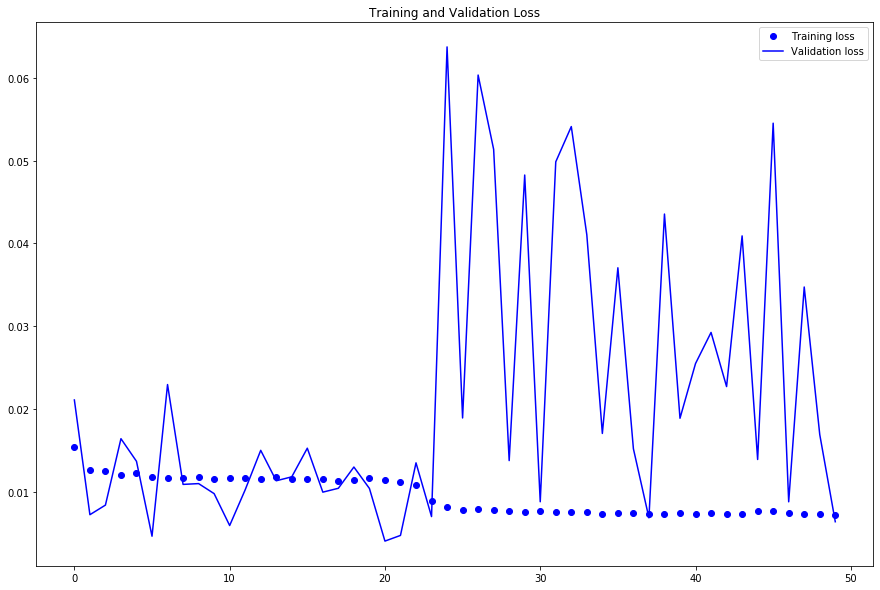

In [52]:
autoencoder_train = AE.history

loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']

train_PSNR = autoencoder_train.history['PSNR']
val_PSNR = autoencoder_train.history['val_PSNR']

plt.figure(figsize=(15,10))
#plt.subplot(2,2,1)
plt.plot(range(epochs), loss, 'bo', label='Training loss')
plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.savefig('AE_loss_history.pdf')
#plt.subplot(2,2,2)
#plt.plot(range(epochs), train_PSNR, 'bo', label='Training PSNR')
#plt.plot(range(epochs), val_PSNR, 'b', label='Validation PSRN')
#plt.title('Training and Validation PSNR')
#plt.legend()

plt.show()

### 4.5 Predicted, reconstructed & latent space images

In [40]:
#AE = load_model('AE_global_32bs_50e.hd5')

In [44]:
pred = AE.predict(X_test)

encoder = Model(inputs=AE.input, outputs=AE.get_layer('encoded').output)
encoded_states = encoder.predict(X_test)

x_encoded = encoded_states.shape[1]
y_encoded = encoded_states.shape[2]

Test Images (96x96)


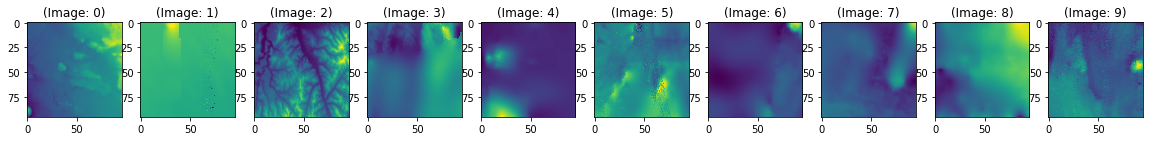

Reconstruction of Test Images (96x96)


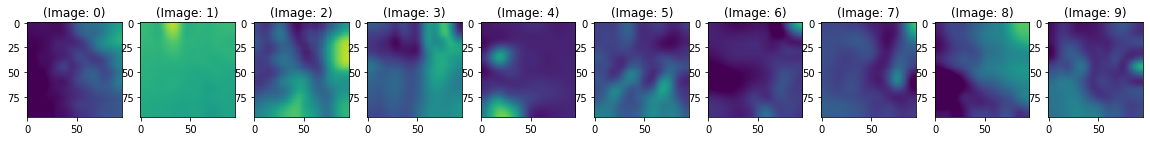

Latent Representation of Test Images (6x6)


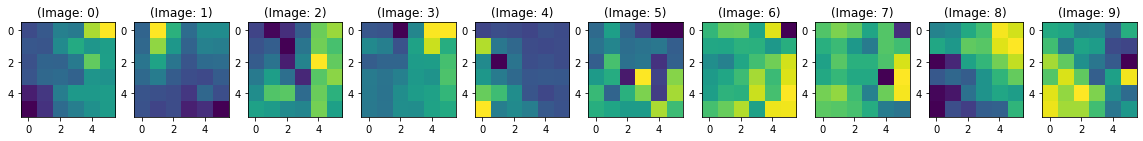

In [45]:
vmin = np.zeros(10)
vmax = np.zeros(10)

plt.figure(figsize=(20, 4))
print("Test Images (" + str(y) + "x" + str(x) + ")")
for i in range(10):
    plt.subplot(2, 10, i+1)
    vmin[i] = np.min(X_test[i, ..., 0])
    vmax[i] = np.max(X_test[i, ..., 0])
    plt.imshow(X_test[i, ..., 0], norm=plt.Normalize(vmin=vmin[i], vmax=vmax[i]))
    plt.title("(Image: " + str(i) + ")")
plt.show()

plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images (" + str(y) + "x" + str(x) + ")")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], norm=plt.Normalize(vmin=vmin[i], vmax=vmax[i]))
    plt.title("(Image: " + str(i) + ")")
plt.show()

plt.figure(figsize=(20, 4))
print("Latent Representation of Test Images (" + str(y_encoded) + "x" + str(x_encoded) + ")")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(encoded_states[i, ..., 0])#, norm=plt.Normalize())
    plt.title("(Image: " + str(i) + ")")
plt.show()

In [43]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

# 5. Reconstruction Errors

#### On Test set

In [46]:
error_test = np.linalg.norm(X_test - pred, axis=(1,2))
PSNR_test = [PSNR_np(X_test[i], pred[i]) for i in range(X_test.shape[0])]
np.linalg.norm(error_test), np.mean(PSNR_test)

(36.08934088957792, 44.332834123263844)

In [47]:
x1 = np.argmax(error_test)
x2 = np.argmin(PSNR_test)
error_test[x1], PSNR_test[x2]

(array([10.66760731]), 19.08408347509414)

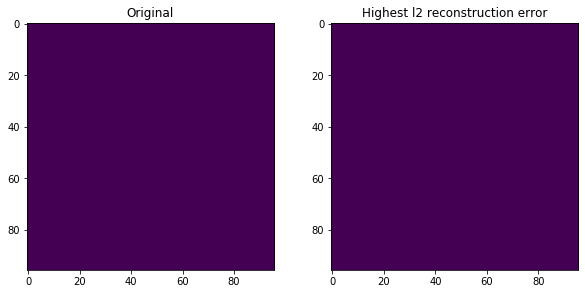

In [48]:
vmin = np.min(X_test[x1, :, :, 0])
vmax = np.max(X_test[x1, :, :, 0])

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Original")
plt.imshow(X_test[x1, :, :, 0], norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.subplot(2,2,2)
plt.title("Highest l2 reconstruction error")
plt.imshow(pred[x1, :, :, 0], norm=plt.Normalize(vmin=vmin, vmax=vmax))

#### Total Reconstruction error

In [49]:
data_reconstructed = AE.predict(data.reshape(-1, y, x, 1)).reshape(-1, y, x)

error_total = np.linalg.norm(data - data_reconstructed, axis=(1,2))
PSNR_total  = [PSNR_np(data[i], data_reconstructed[i]) for i in range(data.shape[0])]
np.linalg.norm(error_total), np.mean(PSNR_total)

(153.52520829279175, 44.4322064012098)

In [50]:
x3 = np.argmax(error_total)
x4 = np.argmin(PSNR_total)
error_total[x3], PSNR_total[x4]

(10.667607307434082, 19.08408347509414)

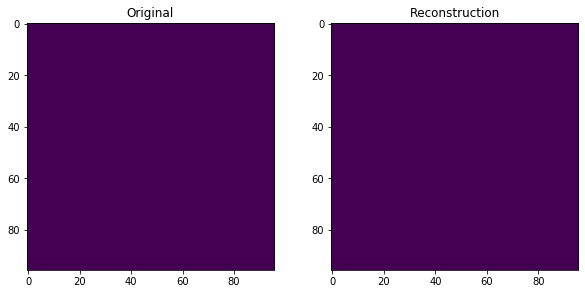

In [51]:
vmin = np.min(data[x3, :, :])
vmax = np.max(data[x3, :, :])

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Original")
plt.imshow(data[x3, :, :], norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.subplot(2,2,2)
plt.title("Reconstruction")
plt.imshow(data_reconstructed[x3, :, :], norm=plt.Normalize(vmin=vmin, vmax=vmax))

# 6. World map in latent space

#### Reshape to match model input shape

In [50]:
data_encoded = data.reshape(-1, y, x, 1)

Values are already [0,1]

#### Encode entire dataset

In [51]:
data_encoded = encoder.predict(data_encoded)

In [52]:
data_encoded.shape

(405000, 6, 6, 256)

In [53]:
gc.collect()

18759

#### Retransform to one big matrix

In [54]:
Z_encoded = np.zeros([int(ratio_y)*y_encoded, int(ratio_x)*x_encoded])
Z_encoded.shape

(2700, 5400)

In [55]:
i=0
for r in range(0, Z_encoded.shape[0], y_encoded):
    for c in range(0, Z_encoded.shape[1], x_encoded):
        Z_encoded[r:r+y_encoded, c:c+x_encoded] = data_encoded[i, ..., 0].T
        i = i + 1

#### Plot latent space representation

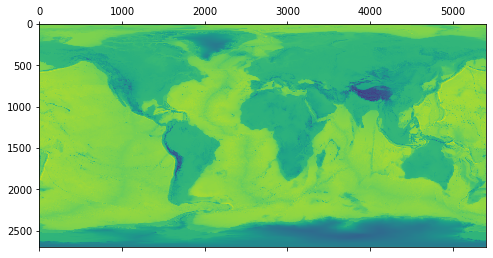

In [56]:
if Hawaii==True:
    plt.figure(figsize=(15,15))
    plt.subplot(2,2,1)
    plt.title("Original")
    plt.imshow(Z)
    plt.subplot(2,2,2)
    plt.title("Latent")
    plt.imshow(Z_encoded)
else:
    plt.matshow(Z_encoded)

In [58]:
print('Original space: ' + str(dim2) + 'x' + str(dim1))
print('Reduced space:  ' + str(Z_encoded.shape[0]) + 'x' + str(Z_encoded.shape[1]))
print('--> reduction of ' + str((1 - Z_encoded.shape[0]*Z_encoded.shape[1]/dim1/dim2)*100) + '%')

Original space: 43200x86400
Reduced space:  10800x21600
--> reduction of 93.75%


In [59]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [52]:
if Hawaii==True:
    #Z_reconstructed = np.zeros([int(ratio_y)*y, int(ratio_x)*x])
    Z_reconstructed = Z.copy()

    i=0
    for r in range(0, Z.shape[0]-cutoff_y, y):
        for c in range(0, Z.shape[1]-cutoff_x, x):
            Z_reconstructed[r:r+y, c:c+x] = data_reconstructed[i, ..., 0].T
            i = i + 1
            
    #Z_reconstructed[dim2-cutoff_y:, dim1-cutoff_x:] = Z[dim2-cutoff_y:, dim1-cutoff_x:]

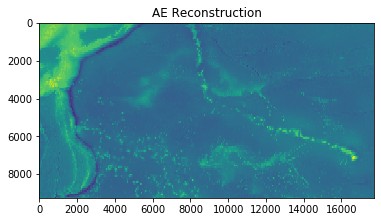

In [54]:
plt.imshow(Z_reconstructed, norm=plt.Normalize(vmin=np.min(Z), vmax=np.max(Z)))
plt.title("AE Reconstruction")
plt.savefig('tohoku_2020/summary_02_AE.pdf')